### **Mount Drive, Files upload (if needed), Load data from pkl file (if needed, later a file structure will be locally created)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
import os

In [ ]:
files.upload()

{}

In [ ]:
# Load data

import pickle

# Cargar images_data desde el archivo usando pickle (15 segundos).
# Mucho mas rapido que volver a leer las imagenes cada vez (49 segundos)
##############################################
# Una vez salvado empezar desde aqui siempre #
##############################################

ruta_completa = '/content/drive/MyDrive/Colab Notebooks/images_data.pkl'

with open(ruta_completa, 'rb') as f:
    images_data = pickle.load(f)

### **Check GPU and Runtime (Runtime>Change runtime type and select GPU as Hardware accelerator)**

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU está disponible")
else:
    device = torch.device("cpu")
    print("GPU no está disponible, usando CPU")


GPU no está disponible, usando CPU


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Aug  9 16:23:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### **Generators with data augmentation (start always from here once the train and test directories are saved)**

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from PIL import Image

train_data_generator = ImageDataGenerator(
        preprocessing_function = preprocess_input, # normalizacion, Reordenamiento de Canales...
        # data augmentation
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        zoom_range = 0.4, # zoom 1.1 caused huge distortion!!! ====> with 0.4 OK
        horizontal_flip = True
        )
# he probado con transformaciones mas fuertes como rotation_range = 100, width_shift_range=0.2, height_shift_range = 0.2, shear_range = 0.6, zoom_range = 0.4
# conducen a mucho pero performance. Conclusion: transformaciones que sean lo mas suaves posibles, lo justo para evitar overfitting, pero ni una pizca mas

test_data_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input)

In [ ]:
batch_size = 64


train_generator = train_data_generator.flow_from_directory(directory="/content/drive/MyDrive/Colab Notebooks/Train_original",
                                                           class_mode ="sparse",
                                                          target_size = (224 , 224),
                                                          batch_size = batch_size)

test_generator = test_data_generator.flow_from_directory(directory="/content/drive/MyDrive/Colab Notebooks/Test_original",
                                                         class_mode ="sparse",
                                                        target_size = (224 , 224),
                                                        batch_size = batch_size)

Found 4426 images belonging to 12 classes.
Found 1113 images belonging to 12 classes.


In [ ]:
# Visually check data Augmentation

import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os

def random_index(x, num_of_samples):
    indices = np.random.choice(num_of_samples, size=x, replace=False)
    return indices


# Visualización de varios resultados de aumentación de datos
fig, ax = plt.subplots(12, 6, figsize=(20, 48))

# Obtener lista de subdirectorios (clases)
class_directories = sorted(os.listdir(train_generator.directory))

i = 0
for directory in class_directories:
    class_path = os.path.join(train_generator.directory, directory)
    num_of_samples = len(os.listdir(class_path))
    indice = random_index(1, num_of_samples)

    image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg') or f.endswith('.png')]
    image_path = os.path.join(class_path, image_files[indice[0]])
    ax[i, 0].imshow(io.imread(image_path))
    ax[i, 0].set_title(directory, fontstyle="italic", fontweight='bold', fontsize=9)
    ax[i, 0].axis("off")

    for j in range (1,6):
        ax[i, j].imshow(train_data_generator.random_transform(io.imread(image_path)))
        ax[i, j].set_title("Aumentado")
        ax[i, j].axis("off")
    i += 1

Output hidden; open in https://colab.research.google.com to view.

### **model definition, training and save the model and the training history**



In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

n_class = 12

# VGG16
base_model = VGG16(weights='imagenet', include_top=False)
# Freeze VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model) # add VGG16
model.add(GlobalAveragePooling2D())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
#model.add(Dense(n_class + 1, activation='softmax'))
model.add(Dense(n_class, activation='softmax'))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
import pickle
# Save model and history
def save_model_and_history(model, history_list, filename_sufix):
    model_filename = f'/content/drive/MyDrive/Colab Notebooks/model_{filename_sufix}.h5'
    history_filename = f'/content/drive/MyDrive/Colab Notebooks/histories_{filename_sufix}.pkl'
    model.save(model_filename)
    with open(history_filename, 'wb') as file:
        pickle.dump(history_list, file)

In [ ]:
def train_model(model, lr, epochs, model_par):
  model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['acc'])
  history = model.fit_generator(generator        = model_par[0],
                                validation_data  = model_par[1],
                                steps_per_epoch  = model_par[2],
                                validation_steps = model_par[3],
                                epochs           = epochs,
                                )
  return history.history

In [ ]:
# saving intermadiate stages cause google can disconect you
import math
import pickle

# Calculate the correct validation_steps
validation_steps = math.ceil(1113 / batch_size)
steps_per_epoch = math.ceil(4426 / batch_size)
history_list = []
model_par = [train_generator, test_generator, steps_per_epoch, validation_steps]

# 20 epochs lr = 0.001
history_list.append(train_model(model, 0.001, 20, model_par))
save_model_and_history(model, history_list, 10) # Check that model_# history_list_# does not exist where # is a number

# de-freeze
for layer in base_model.layers[-4:]:
    layer.trainable = True

# 30 epochs lr = 0.0001
history_list.append(train_model(model, 0.0001, 30, model_par))
save_model_and_history(model, history_list, 11) # Check that model_# history_list_# does not exist where # is a number

<ipython-input-7-3c37c4c0b5d8>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator        = model_par[0],


Epoch 1/20
70/70 [==============================] - 4264s 61s/step - loss: 1.9487 - acc: 0.3850 - val_loss: 1.2712 - val_acc: 0.5337
Epoch 2/20
70/70 [==============================] - 71s 1s/step - loss: 1.2965 - acc: 0.5441 - val_loss: 1.0789 - val_acc: 0.6164
Epoch 3/20
70/70 [==============================] - 71s 1s/step - loss: 1.1120 - acc: 0.6069 - val_loss: 0.9746 - val_acc: 0.6586
Epoch 4/20
70/70 [==============================] - 78s 1s/step - loss: 1.0345 - acc: 0.6279 - val_loss: 0.9245 - val_acc: 0.6361
Epoch 5/20
70/70 [==============================] - 72s 1s/step - loss: 0.9705 - acc: 0.6539 - val_loss: 0.8540 - val_acc: 0.6864
Epoch 6/20
70/70 [==============================] - 72s 1s/step - loss: 0.9209 - acc: 0.6695 - val_loss: 0.8730 - val_acc: 0.6945
Epoch 7/20
70/70 [==============================] - 72s 1s/step - loss: 0.8615 - acc: 0.6891 - val_loss: 0.7565 - val_acc: 0.7358
Epoch 8/20
70/70 [==============================] - 77s 1s/step - loss: 0.8061 - acc: 0

In [ ]:
# Performance analisis

### **Performance analisis**

In [1]:
######################################################
# load my model and history
######################################################
import pickle
from keras.models import load_model

# Cargar el modelo
model = load_model('/content/drive/MyDrive/Colab Notebooks/model_resize_15-15.h5')

# Cargar la lista de historias
with open('/content/drive/MyDrive/Colab Notebooks/histories_resize_15-15.pkl', 'rb') as file:
    history_list = pickle.load(file)

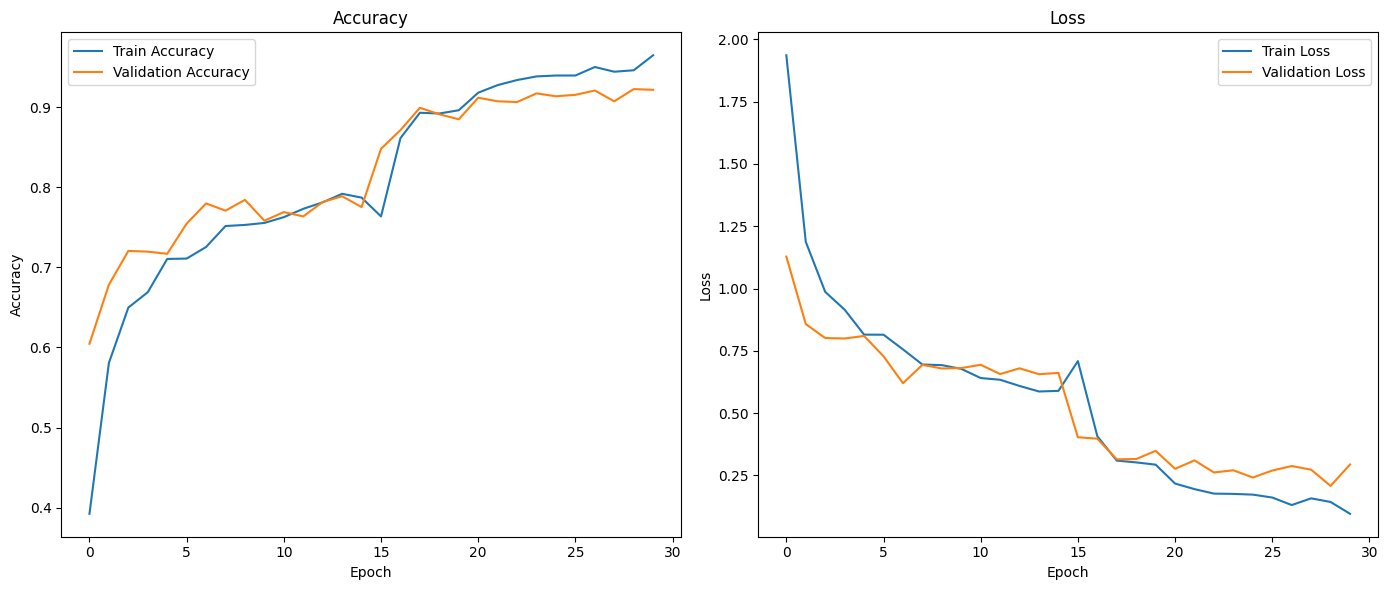

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Crear una figura y ejes para el gráfico
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

history_acc = []
history_val_acc = []
history_loss = []
history_val_loss = []

# Recopilar las precisiones (accuracy) de todas las historias en history_list
for history in history_list:
    history_acc.extend(history['acc'])
    history_val_acc.extend(history['val_acc'])
    history_loss.extend(history['loss'])
    history_val_loss.extend(history['val_loss'])

# Graficar la precisión (accuracy) en función de las épocas
axes[0].plot(history_acc, label='Train Accuracy')
axes[0].plot(history_val_acc, label='Validation Accuracy')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(history_loss, label='Train Loss')
axes[1].plot(history_val_loss, label='Validation Loss')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Volvemos a definir el test_generator con shuffle=False.
# Esto desactiva la mezcla aleatoria de los datos en cada época durante el proceso de evaluación lo cual es útil para asegurarte
# de que las predicciones coincidan con las etiquetas en el orden correcto.
test_generator = test_data_generator.flow_from_directory(directory="/content/drive/MyDrive/Colab Notebooks/Test_original",
                                                         class_mode ="sparse",
                                                        target_size = (224 , 224),
                                                        batch_size = batch_size,
                                                        shuffle=False)

# Obtener el número total de muestras en el conjunto de prueba
num_samples_test = test_generator.samples
print("num_samples_test", num_samples_test)

# Obtener las etiquetas reales del conjunto de prueba
y_true = test_generator.classes

# Realizar predicciones en el conjunto de prueba
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convertir las predicciones continuas en clases
predicted_classes = np.argmax(predictions, axis=1)

print("length y_true", len(y_true))
print("length predicted_classes", len(predicted_classes))

# Mostrar el classification report
print(classification_report(y_true, predicted_classes))


num_samples_test 1113
18/18 [==============================] - 655s 36s/step
length y_true 1113
length predicted_classes 1113
              precision    recall  f1-score   support

           0       0.89      0.40      0.56        62
           1       0.99      0.99      0.99        91
           2       0.99      1.00      0.99        67
           3       0.91      0.97      0.94       143
           4       0.91      0.94      0.92        51
           5       0.91      0.92      0.91       108
           6       0.81      0.96      0.88       153
           7       1.00      0.92      0.96        52
           8       0.88      0.97      0.92       122
           9       1.00      0.76      0.87        55
          10       1.00      0.99      1.00       116
          11       0.96      0.95      0.95        93

    accuracy                           0.92      1113
   macro avg       0.94      0.90      0.91      1113
weighted avg       0.93      0.92      0.92      1113



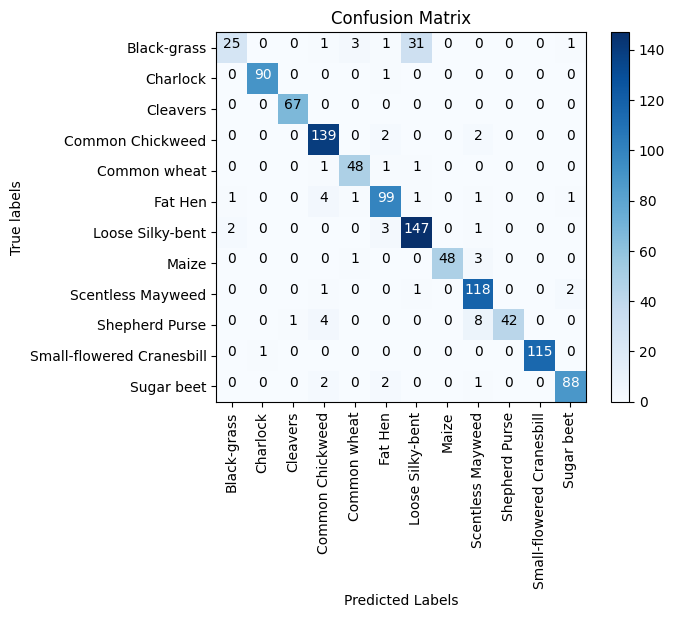

In [ ]:
class_names = list(test_generator.class_indices.keys())

plt.figure()

plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > (cm.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted Labels')

plt.show()



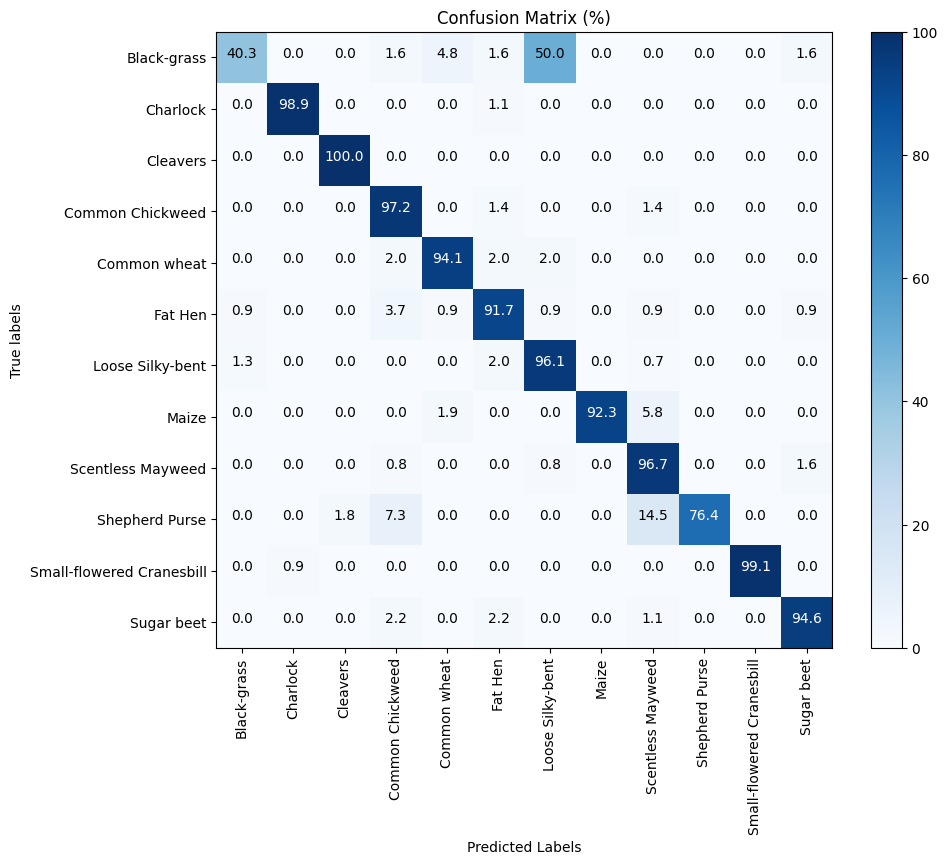

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

# Calculate the confusion matrix
cm = confusion_matrix(y_true, predicted_classes)

# Normalize the confusion matrix to show percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Get class names from test_generator class indices
class_names = list(test_generator.class_indices.keys())

#plt.figure()
plt.figure(figsize=(10, 8))

plt.imshow(cm_percent, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (%)")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm_percent[i, j]:.1f}",  # Display percentage value
             horizontalalignment="center",
             color="white" if cm_percent[i, j] > (cm_percent.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted Labels')

plt.show()


### **Show all confussed images**

In [ ]:
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Obtén el mapeo inverso de nombres de clase a índices
class_indices_inverted = {v: k for k, v in class_indices.items()}

confusion_indices = np.where(y_true != predicted_classes)[0]

# Define la ruta del directorio de las imágenes de prueba
test_images_dir = "/content/drive/MyDrive/Colab Notebooks/Test_original"

# Define una función para mostrar imágenes con títulos
def show_images_with_titles(image_paths, titles, font_size=10, cols=6, figsize=(20, 48)):
    rows = len(image_paths) // cols + 1
    plt.figure(figsize=figsize)

    for i, (image_path, title) in enumerate(zip(image_paths, titles)):
        plt.subplot(rows, cols, i + 1)
        img = load_img(image_path, target_size=(224, 224))
        plt.imshow(img)
        plt.title(title, fontsize=font_size)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Obtén rutas de imágenes de confusiones
confusion_image_paths = [os.path.join(test_images_dir, test_generator.filenames[idx]) for idx in confusion_indices]

# Genera títulos usando nombres de clase en lugar de números
confusion_titles = [f"True: {class_names[y_true[idx]]}, Pred: {class_names[predicted_classes[idx]]}" for idx in confusion_indices]

# Muestra las imágenes de confusiones con nombres de clase en los títulos
show_images_with_titles(confusion_image_paths[:len(confusion_indices)], confusion_titles[:len(confusion_indices)], font_size=8)



Output hidden; open in https://colab.research.google.com to view.